In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

2025-10-20 18:13:35.764447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760984015.963807      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760984016.020155      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

import os

base_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

image_paths = []
mask_paths = []

for folder in os.listdir(base_dir):
    path = os.path.join(base_dir, folder)

    if not os.path.isdir(path):
        continue  

    imgs = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" not in f])
    masks = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" in f])

    image_paths.extend(imgs)
    mask_paths.extend(masks)

print(f"Num images: {len(image_paths)}")
print(f"Num Masks: {len(mask_paths)}")

assert len(image_paths) == len(mask_paths)


Num images: 3929
Num Masks: 3929


In [4]:

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 256

X = []
Y = []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None or mask is None:
        print(f"Error loading: {img_path}")
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    img = img / 255.0
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print(f" Loaded images: {X.shape}, masks: {Y.shape}")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f" Train: {X_train.shape}, Test: {X_test.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(8).prefetch(tf.data.AUTOTUNE)


 Loaded images: (3929, 256, 256, 3), masks: (3929, 256, 256, 1)
 Train: (3143, 256, 256, 3), Test: (786, 256, 256, 3)


I0000 00:00:1760984178.128597      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


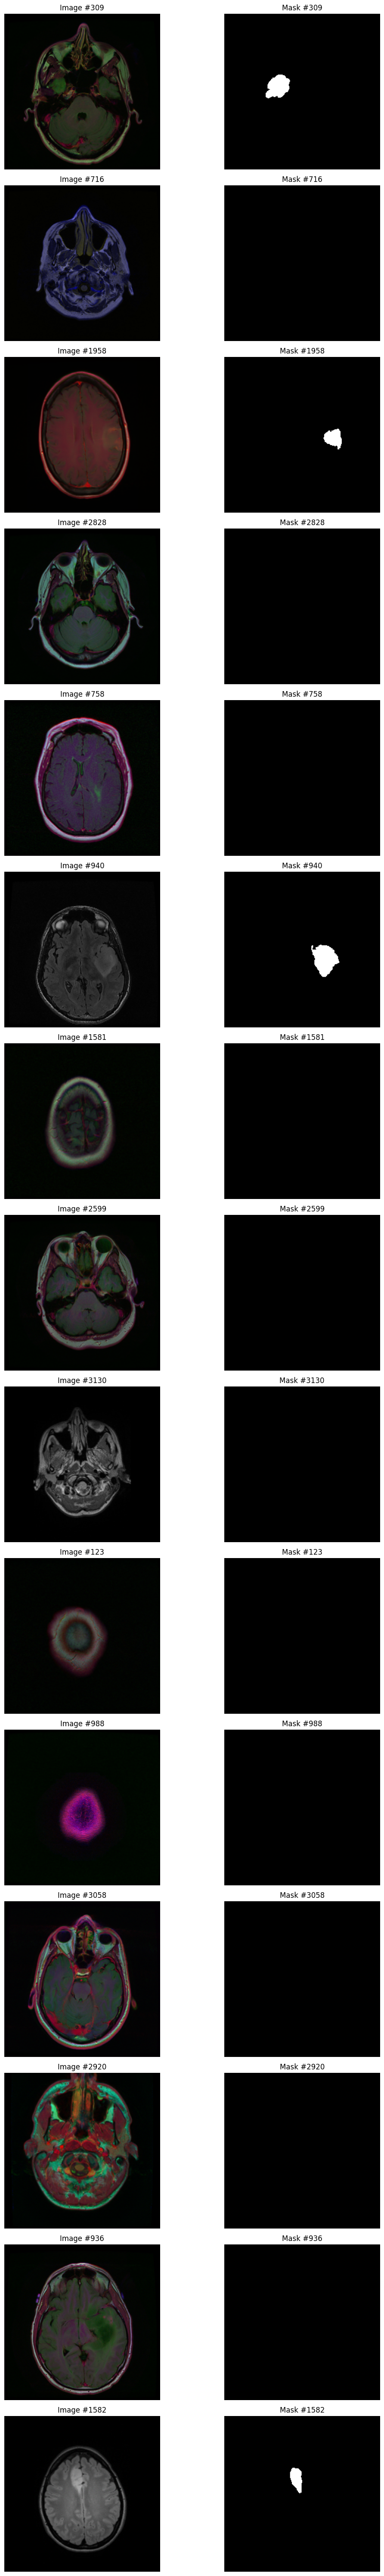

In [5]:
import matplotlib.pyplot as plt
import random
import numpy as np

num_samples = 15
indices = random.sample(range(len(X_train)), num_samples)

plt.figure(figsize=(12, 4 * num_samples))

for i, idx in enumerate(indices):
    img = X_train[idx]
    mask = Y_train[idx]

   
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    
    img_disp = np.clip(img, 0, 1)
    mask_disp = np.squeeze(mask) 

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(img_disp)
    plt.title(f"Image #{idx}")
    plt.axis("off")

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(mask_disp, cmap="gray")
    plt.title(f"Mask #{idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:

from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.BatchNormalization()(c1)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
c1 = layers.Dropout(0.3)(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Dropout(0.3)(c2)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Dropout(0.3)(c3)
c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

# Decoder
u5 = layers.UpSampling2D((2, 2))(c4)
u5 = layers.concatenate([u5, c3])
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
u5 = layers.BatchNormalization()(u5)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

u6 = layers.UpSampling2D((2, 2))(c5)
u6 = layers.concatenate([u6, c2])
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Dropout(0.3)(c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

u7 = layers.UpSampling2D((2, 2))(c6)
u7 = layers.concatenate([u7, c1])
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Dropout(0.3)(c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

model = models.Model(inputs, outputs)





import tensorflow as tf
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.7, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())



model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric]
)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]  

 Total params: 7,783,169 (29.69 MB)

 Trainable params: 7,783,041 (29.69 MB)

 Non-trainable params: 128 (512.00 B)

In [7]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)
]



history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=20,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40


I0000 00:00:1760984200.522071      97 service.cc:148] XLA service 0x7a03d0003a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760984200.523437      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760984201.456528      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/393 ━━━━━━━━━━━━━━━━━━━━ 3:35:01 33s/step - accuracy: 0.9757 - iou_metric: 0.0000e+00 - loss: 0.5387

I0000 00:00:1760984222.533420      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9896 - iou_metric: 0.0000e+00 - loss: 0.0618

E0000 00:00:1760984292.773075      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760984293.008161      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


393/393 ━━━━━━━━━━━━━━━━━━━━ 134s 258ms/step - accuracy: 0.9896 - iou_metric: 0.0000e+00 - loss: 0.0617 - val_accuracy: 0.9892 - val_iou_metric: 0.0000e+00 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 2/40
393/393 ━━━━━━━━━━━━━━━━━━━━ 73s 187ms/step - accuracy: 0.9901 - iou_metric: 0.0043 - loss: 0.0337 - val_accuracy: 0.9907 - val_iou_metric: 0.0000e+00 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 3/40
393/393 ━━━━━━━━━━━━━━━━━━━━ 73s 187ms/step - accuracy: 0.9910 - iou_metric: 0.0563 - loss: 0.0332 - val_accuracy: 0.9908 - val_iou_metric: 0.0000e+00 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 4/40
393/393 ━━━━━━━━━━━━━━━━━━━━ 73s 185ms/step - accuracy: 0.9911 - iou_metric: 0.0632 - loss: 0.0322 - val_accuracy: 0.9835 - val_iou_metric: 0.1886 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 5/40
393/393 ━━━━━━━━━━━━━━━━━━━━ 73s 185ms/step - accuracy: 0.9902 - iou_metric: 0.0297 - loss: 0.0331 - val_accuracy: 0.9899 - val_iou_metric: 0.0000e+00 - val_loss: 0.0347 - learnin

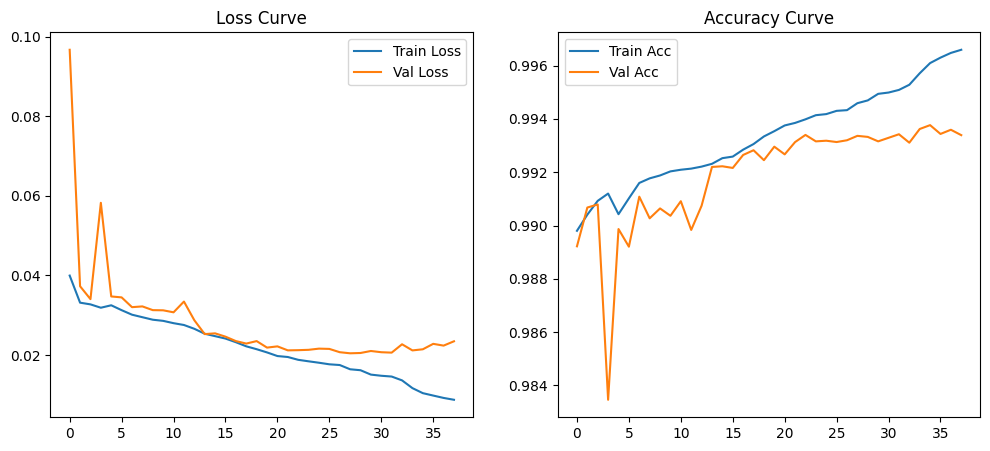

In [8]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [9]:

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.float32)

smooth = 1e-6
dice_scores = []
iou_scores = []
acc_per_class = []

for i in range(len(Y_test)):
    y_true = Y_test[i].flatten()
    y_p = y_pred[i].flatten()

    intersection = np.sum(y_true * y_p)
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_p) + smooth)
    iou = (intersection + smooth) / (np.sum(y_true + y_p) - intersection + smooth)
    acc = np.mean(y_true == y_p)

    dice_scores.append(dice)
    iou_scores.append(iou)
    acc_per_class.append(acc)

dice_scores = [np.mean(dice_scores)]
iou_scores = [np.mean(iou_scores)]
acc_per_class = [np.mean(acc_per_class)]

print(f" Dice: {dice_scores[0]:.4f}")
print(f" IoU: {iou_scores[0]:.4f}")
print(f" Accuracy: {acc_per_class[0]:.4f}")

num_classes = 1  

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

E0000 00:00:1760987053.818815      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760987054.057279      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 687ms/step
 Dice: 0.7187
 IoU: 0.6836
 Accuracy: 0.9934


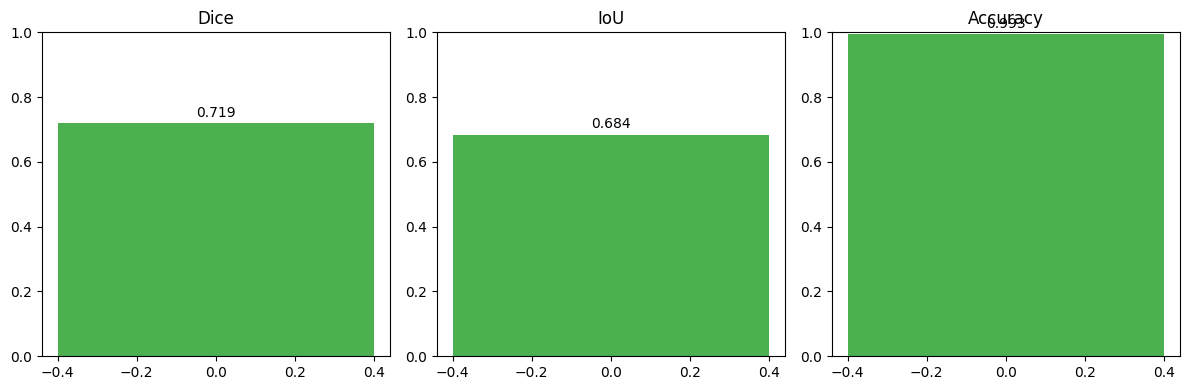

In [10]:

import numpy as np
import matplotlib.pyplot as plt

metrics = ['Dice', 'IoU', 'Accuracy']
values = [dice_scores, iou_scores, acc_per_class]

plt.figure(figsize=(12,4))
for i, (metric, vals) in enumerate(zip(metrics, values)):
    plt.subplot(1,3,i+1)
    plt.bar(range(len(vals)), vals, color=['#4CAF50'])
    plt.title(metric)
    plt.ylim(0,1)
    for j, v in enumerate(vals):
        plt.text(j, v+0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


/tmp/ipykernel_37/2515828812.py:31: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()


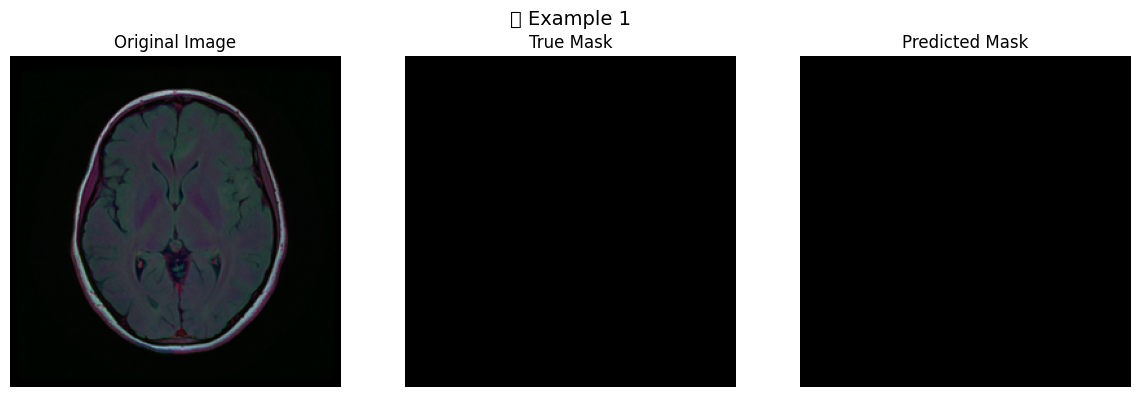

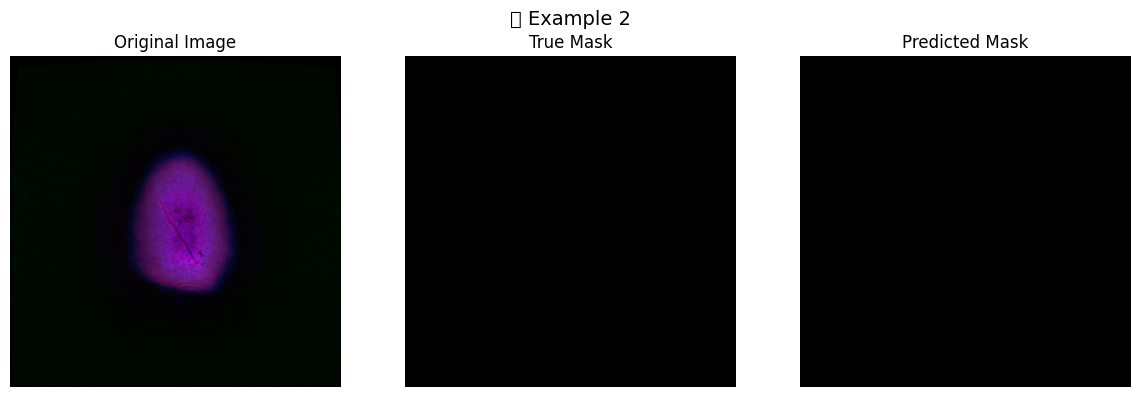

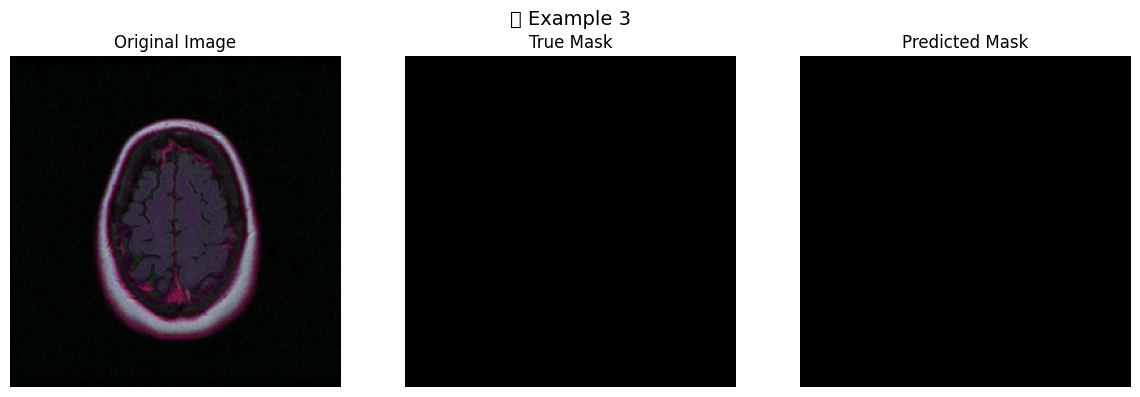

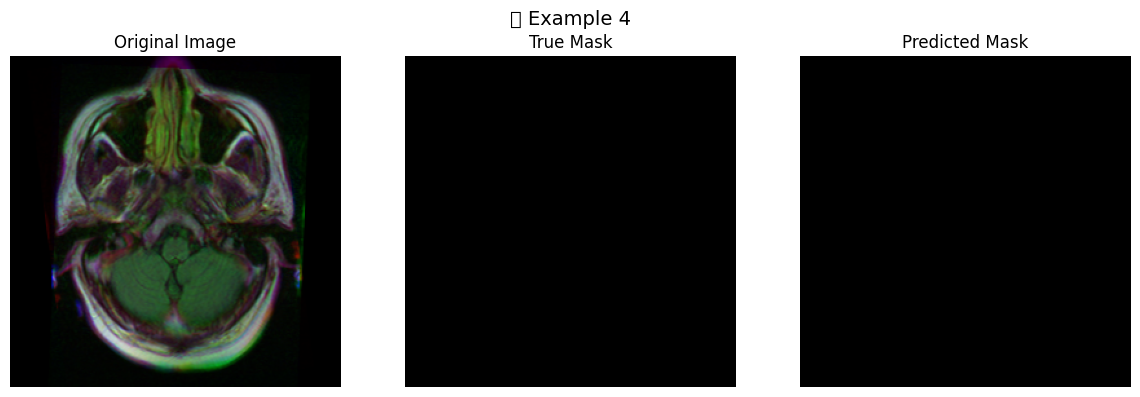

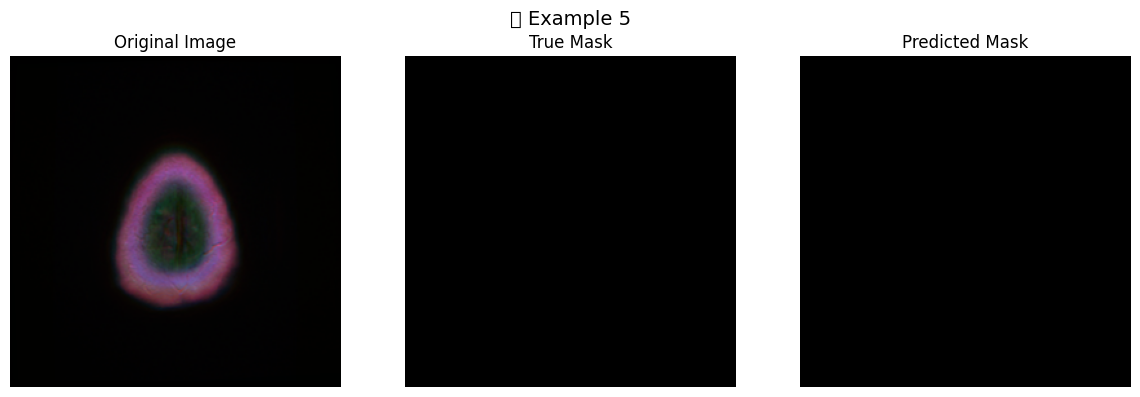

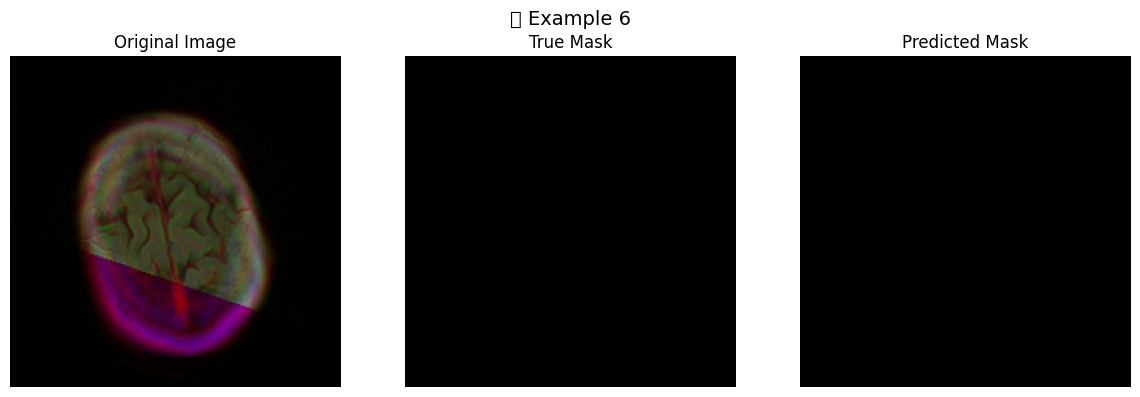

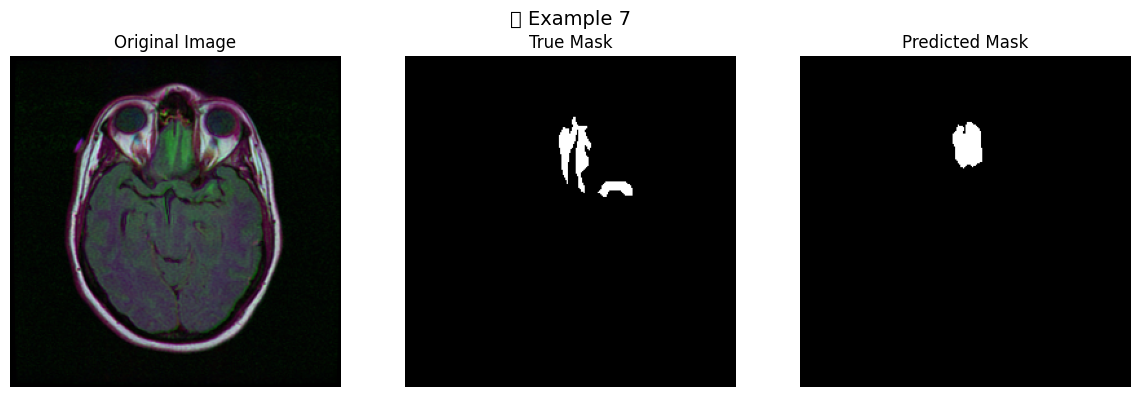

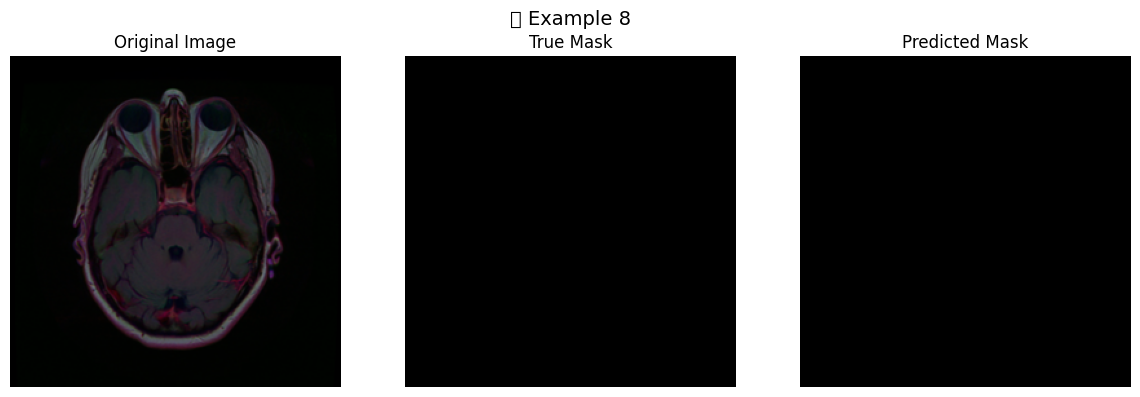

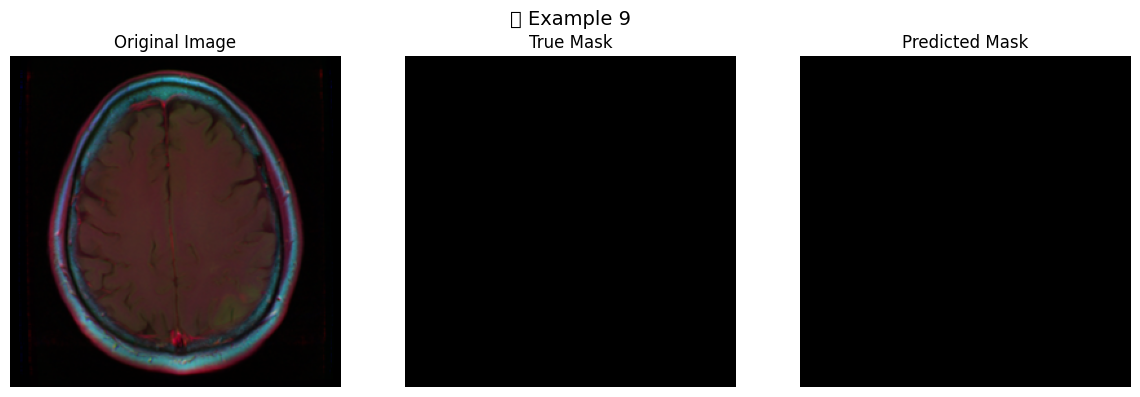

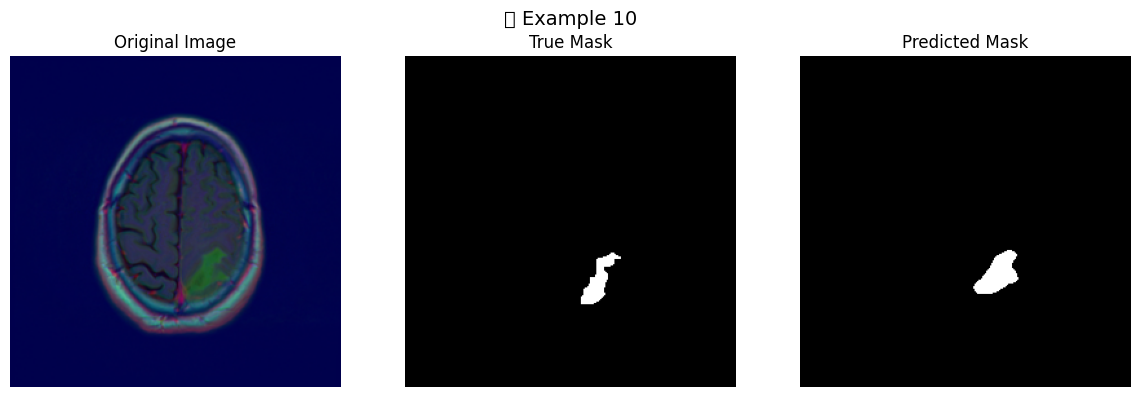

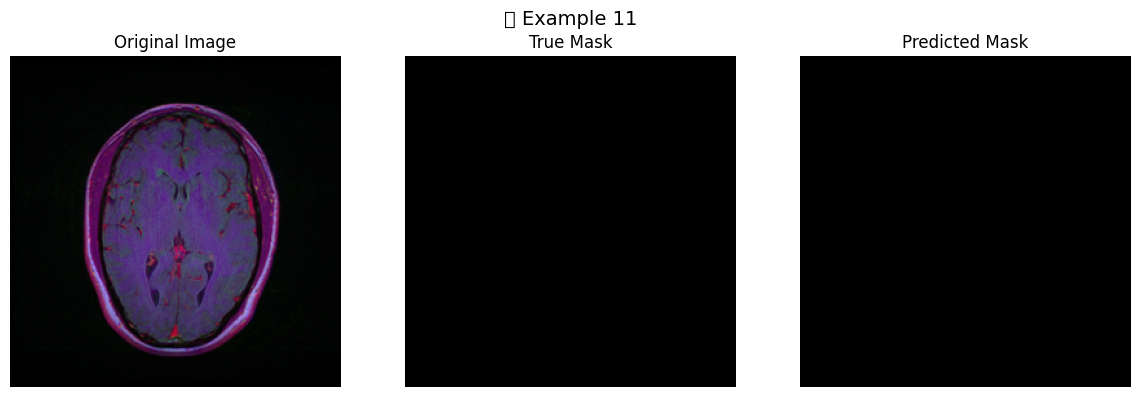

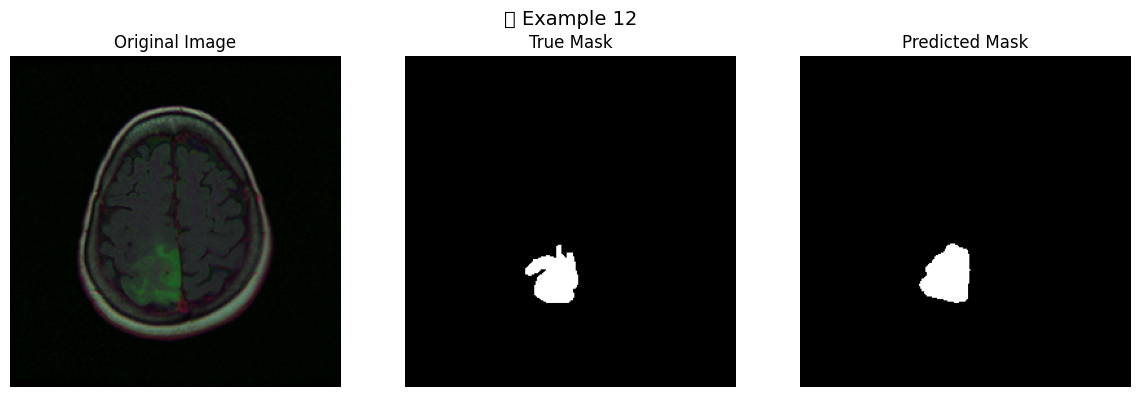

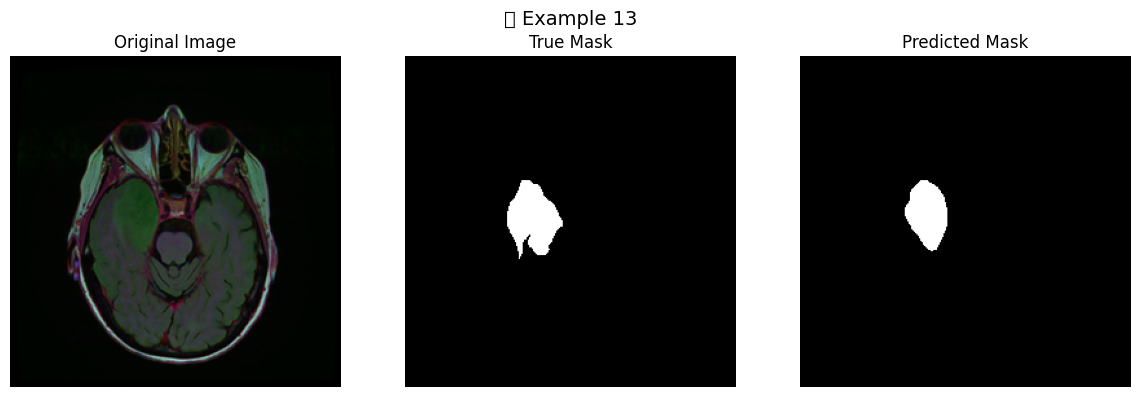

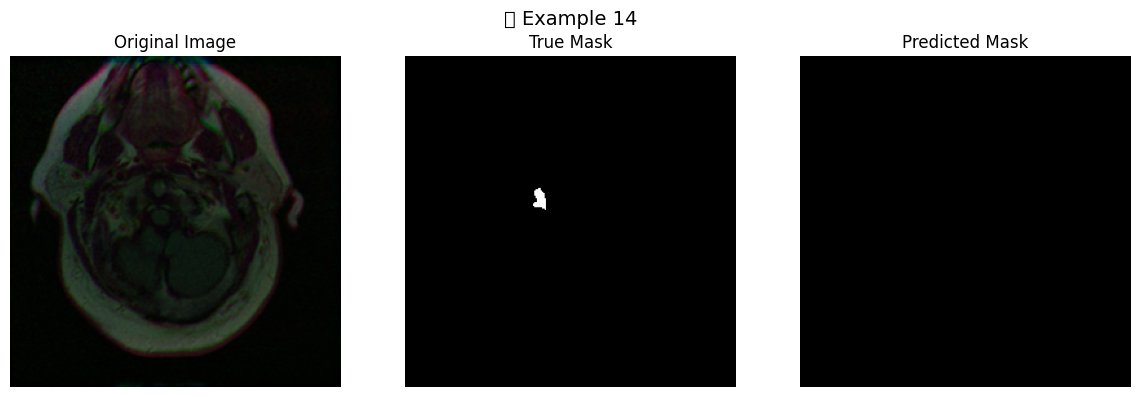

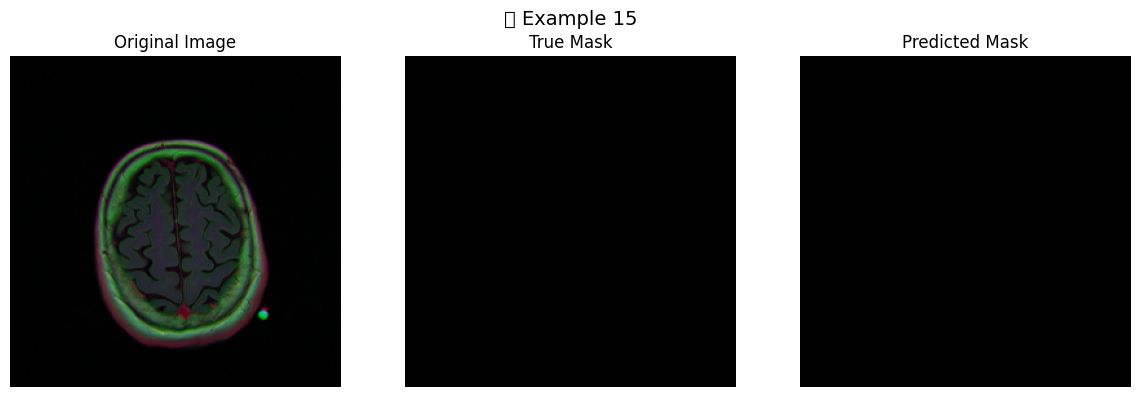

In [12]:

num_examples = 15

for i in range(num_examples):
    idx = random.randint(0, len(X_test) - 1)
    
    sample_img = X_test[idx]
    sample_mask_true = Y_test[idx]
    sample_mask_pred = y_pred[idx]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"🔹 Example {i+1}", fontsize=14)

  
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title("Original Image")
    plt.axis('off')

   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask_true[:, :, 0], cmap='gray')
    plt.title("True Mask")
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(sample_mask_pred[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [13]:
model.save("unet_brain_tumor_final.h5")
print("✅ Model saved as unet_brain_tumor_final.h5")

✅ Model saved as unet_brain_tumor_final.h5


In [14]:
import cv2

def draw_bounding_boxes(image, mask, min_area=200):

    img = (image * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)

 
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxed_img = img.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area: 
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(boxed_img, f"Area:{int(area)}", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return boxed_img

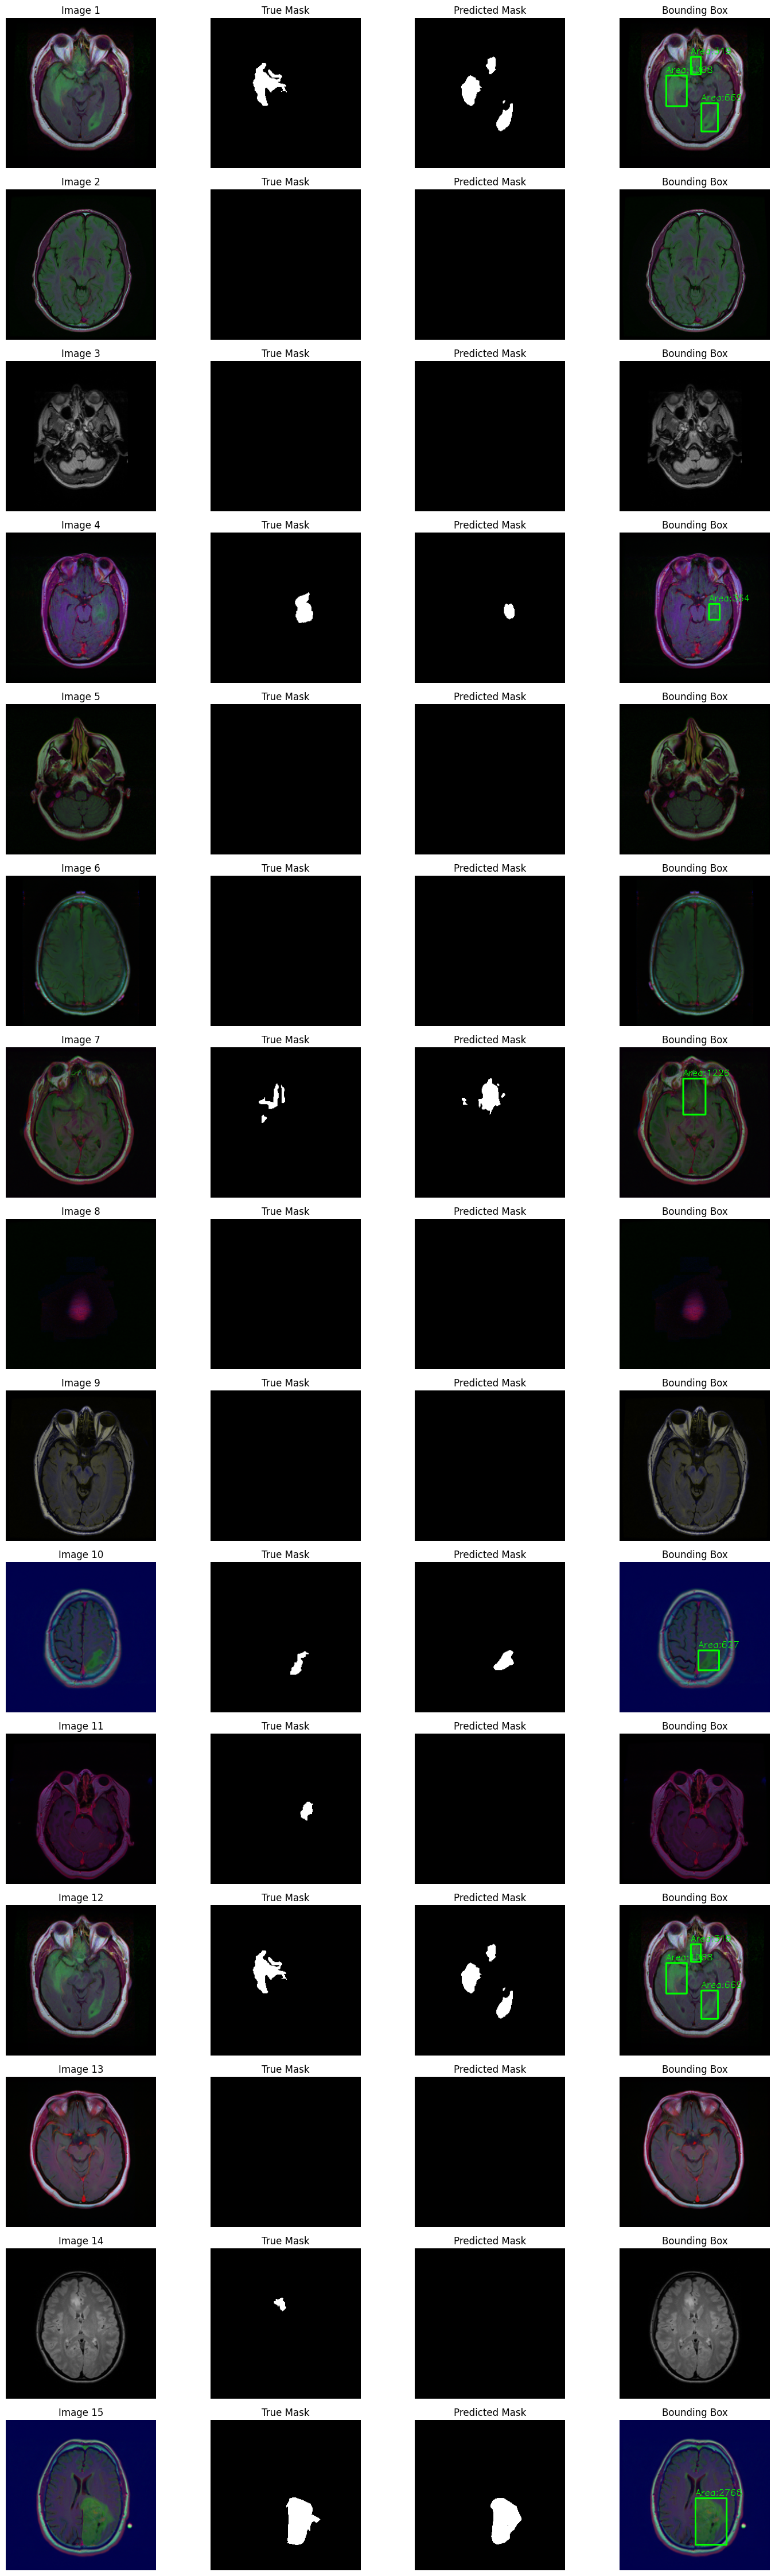

In [15]:
import matplotlib.pyplot as plt
import random


num_samples = 15  

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    
    idx = random.randint(0, len(X_test) - 1)
    sample_img = X_test[idx]
    sample_mask_true = Y_test[idx]
    sample_mask_pred = y_pred[idx]

  
    boxed_result = draw_bounding_boxes(sample_img, sample_mask_pred[:, :, 0])

  
    plt.subplot(num_samples, 4, i * 4 + 1)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title(f"Image {i+1}")

    plt.subplot(num_samples, 4, i * 4 + 2)
    plt.imshow(sample_mask_true[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("True Mask")

    plt.subplot(num_samples, 4, i * 4 + 3)
    plt.imshow(sample_mask_pred[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("Predicted Mask")

    plt.subplot(num_samples, 4, i * 4 + 4)
    plt.imshow(boxed_result)
    plt.axis('off')
    plt.title("Bounding Box")

plt.tight_layout()
plt.show()
